In [1]:
import json
import math
import os
from tqdm import tqdm
# tqdm.pandas()
import cv2
from PIL import Image

import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from keras.models import model_from_json
from keras import layers
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
from PIL import Image
print(os.listdir('../input'))

im_size = 256

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

['aptos-zoom-rs-1', 'aptos-effb5-changing-lr', 'aptos2019-blindness-detection']


In [2]:
''' ## Credits
All credits are due to https://github.com/qubvel/efficientnet
Thanks so much for your contribution!

## Usage:
Adding this utility script to your kernel, and you will be able to 
use all models just like standard Keras pretrained model. For details see
https://www.kaggle.com/c/aptos2019-blindness-detection/discussion/100186

## Pretrained Weights
https://www.kaggle.com/ratthachat/efficientnet-keras-weights-b0b5/
'''

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
from skimage.transform import resize
import tensorflow as tf
import keras.backend as K
import keras.layers as KL
from keras.initializers import Initializer
from keras.utils.generic_utils import get_custom_objects

import os
import re
import collections
import math
import six
from six.moves import xrange  # pylint: disable=redefined-builtin

import keras.models as KM
from keras.utils import get_file

MEAN_RGB = [0.485 * 255, 0.456 * 255, 0.406 * 255]
STDDEV_RGB = [0.229 * 255, 0.224 * 255, 0.225 * 255]

MAP_INTERPOLATION_TO_ORDER = {
    "nearest": 0,
    "bilinear": 1,
    "biquadratic": 2,
    "bicubic": 3,
}


def center_crop_and_resize(image, image_size, crop_padding=32, interpolation="bicubic"):
    assert image.ndim in {2, 3}
    assert interpolation in MAP_INTERPOLATION_TO_ORDER.keys()

    h, w = image.shape[:2]

    padded_center_crop_size = int(
        (image_size / (image_size + crop_padding)) * min(h, w)
    )
    offset_height = ((h - padded_center_crop_size) + 1) // 2
    offset_width = ((w - padded_center_crop_size) + 1) // 2

    image_crop = image[
        offset_height : padded_center_crop_size + offset_height,
        offset_width : padded_center_crop_size + offset_width,
    ]
    resized_image = resize(
        image_crop,
        (image_size, image_size),
        order=MAP_INTERPOLATION_TO_ORDER[interpolation],
        preserve_range=True,
    )

    return resized_image


def preprocess_input(x):
    assert x.ndim in (3, 4)
    assert x.shape[-1] == 3

    x = x - np.array(MEAN_RGB)
    x = x / np.array(STDDEV_RGB)

    return x

class EfficientConv2DKernelInitializer(Initializer):
    """Initialization for convolutional kernels.
    The main difference with tf.variance_scaling_initializer is that
    tf.variance_scaling_initializer uses a truncated normal with an uncorrected
    standard deviation, whereas here we use a normal distribution. Similarly,
    tf.contrib.layers.variance_scaling_initializer uses a truncated normal with
    a corrected standard deviation.
    Args:
      shape: shape of variable
      dtype: dtype of variable
      partition_info: unused
    Returns:
      an initialization for the variable
    """

    def __call__(self, shape, dtype=K.floatx(), **kwargs):
        kernel_height, kernel_width, _, out_filters = shape
        fan_out = int(kernel_height * kernel_width * out_filters)
        return tf.random_normal(
            shape, mean=0.0, stddev=np.sqrt(2.0 / fan_out), dtype=dtype
        )


class EfficientDenseKernelInitializer(Initializer):
    """Initialization for dense kernels.
    This initialization is equal to
      tf.variance_scaling_initializer(scale=1.0/3.0, mode='fan_out',
                                      distribution='uniform').
    It is written out explicitly here for clarity.
    Args:
      shape: shape of variable
      dtype: dtype of variable
    Returns:
      an initialization for the variable
    """

    def __call__(self, shape, dtype=K.floatx(), **kwargs):
        """Initialization for dense kernels.
        This initialization is equal to
          tf.variance_scaling_initializer(scale=1.0/3.0, mode='fan_out',
                                          distribution='uniform').
        It is written out explicitly here for clarity.
        Args:
          shape: shape of variable
          dtype: dtype of variable
        Returns:
          an initialization for the variable
        """
        init_range = 1.0 / np.sqrt(shape[1])
        return tf.random_uniform(shape, -init_range, init_range, dtype=dtype)


conv_kernel_initializer = EfficientConv2DKernelInitializer()
dense_kernel_initializer = EfficientDenseKernelInitializer()


get_custom_objects().update(
    {
        "EfficientDenseKernelInitializer": EfficientDenseKernelInitializer,
        "EfficientConv2DKernelInitializer": EfficientConv2DKernelInitializer,
    }
)

class Swish(KL.Layer):
    def call(self, inputs):
        return tf.nn.swish(inputs)


class DropConnect(KL.Layer):
    def __init__(self, drop_connect_rate=0.0, **kwargs):
        super().__init__(**kwargs)
        self.drop_connect_rate = drop_connect_rate

    def call(self, inputs, training=None):
        def drop_connect():
            keep_prob = 1.0 - self.drop_connect_rate

            # Compute drop_connect tensor
            batch_size = tf.shape(inputs)[0]
            random_tensor = keep_prob
            random_tensor += tf.random_uniform(
                [batch_size, 1, 1, 1], dtype=inputs.dtype
            )
            binary_tensor = tf.floor(random_tensor)
            output = tf.div(inputs, keep_prob) * binary_tensor
            return output

        return K.in_train_phase(drop_connect, inputs, training=training)

    def get_config(self):
        config = super().get_config()
        config["drop_connect_rate"] = self.drop_connect_rate
        return config


get_custom_objects().update({"DropConnect": DropConnect, "Swish": Swish})


IMAGENET_WEIGHTS = {
    "efficientnet-b0": {
        "name": "efficientnet-b0_imagenet_1000.h5",
        "url": "https://github.com/qubvel/efficientnet/releases/download/v0.0.1/efficientnet-b0_imagenet_1000.h5",
        "md5": "bca04d16b1b8a7c607b1152fe9261af7",
    },
    "efficientnet-b0-notop": {
        "name": "efficientnet-b0_imagenet_1000_notop.h5",
        "url": "https://github.com/qubvel/efficientnet/releases/download/v0.0.1/efficientnet-b0_imagenet_1000_notop.h5",
        "md5": "45d2f3b6330c2401ef66da3961cad769",
    },
    "efficientnet-b1": {
        "name": "efficientnet-b1_imagenet_1000.h5",
        "url": "https://github.com/qubvel/efficientnet/releases/download/v0.0.1/efficientnet-b1_imagenet_1000.h5",
        "md5": "bd4a2b82f6f6bada74fc754553c464fc",
    },
    "efficientnet-b1-notop": {
        "name": "efficientnet-b1_imagenet_1000_notop.h5",
        "url": "https://github.com/qubvel/efficientnet/releases/download/v0.0.1/efficientnet-b1_imagenet_1000_notop.h5",
        "md5": "884aed586c2d8ca8dd15a605ec42f564",
    },
    "efficientnet-b2": {
        "name": "efficientnet-b2_imagenet_1000.h5",
        "url": "https://github.com/qubvel/efficientnet/releases/download/v0.0.1/efficientnet-b2_imagenet_1000.h5",
        "md5": "45b28b26f15958bac270ab527a376999",
    },
    "efficientnet-b2-notop": {
        "name": "efficientnet-b2_imagenet_1000_notop.h5",
        "url": "https://github.com/qubvel/efficientnet/releases/download/v0.0.1/efficientnet-b2_imagenet_1000_notop.h5",
        "md5": "42fb9f2d9243d461d62b4555d3a53b7b",
    },
    "efficientnet-b3": {
        "name": "efficientnet-b3_imagenet_1000.h5",
        "url": "https://github.com/qubvel/efficientnet/releases/download/v0.0.1/efficientnet-b3_imagenet_1000.h5",
        "md5": "decd2c8a23971734f9d3f6b4053bf424",
    },
    "efficientnet-b3-notop": {
        "name": "efficientnet-b3_imagenet_1000_notop.h5",
        "url": "https://github.com/qubvel/efficientnet/releases/download/v0.0.1/efficientnet-b3_imagenet_1000_notop.h5",
        "md5": "1f7d9a8c2469d2e3d3b97680d45df1e1",
    },
    "efficientnet-b4": {
        "name": "efficientnet-b4_imagenet_1000.h5",
        "url": "https://github.com/qubvel/efficientnet/releases/download/v0.0.1/efficientnet-b4_imagenet_1000.h5",
        "md5": "01df77157a86609530aeb4f1f9527949",
    },
    "efficientnet-b4-notop": {
        "name": "efficientnet-b4_imagenet_1000_notop.h5",
        "url": "https://github.com/qubvel/efficientnet/releases/download/v0.0.1/efficientnet-b4_imagenet_1000_notop.h5",
        "md5": "e7c3b780f050f8f49c800f23703f285c",
    },
    "efficientnet-b5": {
        "name": "efficientnet-b5_imagenet_1000.h5",
        "url": "https://github.com/qubvel/efficientnet/releases/download/v0.0.1/efficientnet-b5_imagenet_1000.h5",
        "md5": "c31311a1a38b5111e14457145fccdf32",
    },
    "efficientnet-b5-notop": {
        "name": "efficientnet-b5_imagenet_1000_notop.h5",
        "url": "https://github.com/qubvel/efficientnet/releases/download/v0.0.1/efficientnet-b5_imagenet_1000_notop.h5",
        "md5": "a09b36129b41196e0bb659fd84fbdd5f",
    },
}


GlobalParams = collections.namedtuple(
    "GlobalParams",
    [
        "batch_norm_momentum",
        "batch_norm_epsilon",
        "dropout_rate",
        "data_format",
        "num_classes",
        "width_coefficient",
        "depth_coefficient",
        "depth_divisor",
        "min_depth",
        "drop_connect_rate",
    ],
)
GlobalParams.__new__.__defaults__ = (None,) * len(GlobalParams._fields)

BlockArgs = collections.namedtuple(
    "BlockArgs",
    [
        "kernel_size",
        "num_repeat",
        "input_filters",
        "output_filters",
        "expand_ratio",
        "id_skip",
        "strides",
        "se_ratio",
    ],
)
# defaults will be a public argument for namedtuple in Python 3.7
# https://docs.python.org/3/library/collections.html#collections.namedtuple
BlockArgs.__new__.__defaults__ = (None,) * len(BlockArgs._fields)


def efficientnet_params(model_name):
    """Get efficientnet params based on model name."""
    params_dict = {
        # (width_coefficient, depth_coefficient, resolution, dropout_rate)
        "efficientnet-b0": (1.0, 1.0, 224, 0.2),
        "efficientnet-b1": (1.0, 1.1, 240, 0.2),
        "efficientnet-b2": (1.1, 1.2, 260, 0.3),
        "efficientnet-b3": (1.2, 1.4, 300, 0.3),
        "efficientnet-b4": (1.4, 1.8, 380, 0.4),
        "efficientnet-b5": (1.6, 2.2, 456, 0.4),
        "efficientnet-b6": (1.8, 2.6, 528, 0.5),
        "efficientnet-b7": (2.0, 3.1, 600, 0.5),
    }
    return params_dict[model_name]


class BlockDecoder(object):
    """Block Decoder for readability."""

    def _decode_block_string(self, block_string):
        """Gets a block through a string notation of arguments."""
        assert isinstance(block_string, str)
        ops = block_string.split("_")
        options = {}
        for op in ops:
            splits = re.split(r"(\d.*)", op)
            if len(splits) >= 2:
                key, value = splits[:2]
                options[key] = value

        if "s" not in options or len(options["s"]) != 2:
            raise ValueError("Strides options should be a pair of integers.")

        return BlockArgs(
            kernel_size=int(options["k"]),
            num_repeat=int(options["r"]),
            input_filters=int(options["i"]),
            output_filters=int(options["o"]),
            expand_ratio=int(options["e"]),
            id_skip=("noskip" not in block_string),
            se_ratio=float(options["se"]) if "se" in options else None,
            strides=[int(options["s"][0]), int(options["s"][1])],
        )

    def _encode_block_string(self, block):
        """Encodes a block to a string."""
        args = [
            "r%d" % block.num_repeat,
            "k%d" % block.kernel_size,
            "s%d%d" % (block.strides[0], block.strides[1]),
            "e%s" % block.expand_ratio,
            "i%d" % block.input_filters,
            "o%d" % block.output_filters,
        ]
        if block.se_ratio > 0 and block.se_ratio <= 1:
            args.append("se%s" % block.se_ratio)
        if block.id_skip is False:
            args.append("noskip")
        return "_".join(args)

    def decode(self, string_list):
        """Decodes a list of string notations to specify blocks inside the network.
    Args:
      string_list: a list of strings, each string is a notation of block.
    Returns:
      A list of namedtuples to represent blocks arguments.
    """
        assert isinstance(string_list, list)
        blocks_args = []
        for block_string in string_list:
            blocks_args.append(self._decode_block_string(block_string))
        return blocks_args

    def encode(self, blocks_args):
        """Encodes a list of Blocks to a list of strings.
    Args:
      blocks_args: A list of namedtuples to represent blocks arguments.
    Returns:
      a list of strings, each string is a notation of block.
    """
        block_strings = []
        for block in blocks_args:
            block_strings.append(self._encode_block_string(block))
        return block_strings


def efficientnet(
    width_coefficient=None,
    depth_coefficient=None,
    dropout_rate=0.2,
    drop_connect_rate=0.2,
):
    """Creates a efficientnet model."""
    blocks_args = [
        "r1_k3_s11_e1_i32_o16_se0.25",
        "r2_k3_s22_e6_i16_o24_se0.25",
        "r2_k5_s22_e6_i24_o40_se0.25",
        "r3_k3_s22_e6_i40_o80_se0.25",
        "r3_k5_s11_e6_i80_o112_se0.25",
        "r4_k5_s22_e6_i112_o192_se0.25",
        "r1_k3_s11_e6_i192_o320_se0.25",
    ]
    global_params = GlobalParams(
        batch_norm_momentum=0.99,
        batch_norm_epsilon=1e-3,
        dropout_rate=dropout_rate,
        drop_connect_rate=drop_connect_rate,
        data_format="channels_last",
        num_classes=1000,
        width_coefficient=width_coefficient,
        depth_coefficient=depth_coefficient,
        depth_divisor=8,
        min_depth=None,
    )
    decoder = BlockDecoder()
    return decoder.decode(blocks_args), global_params


def get_model_params(model_name, override_params=None):
    """Get the block args and global params for a given model."""
    if model_name.startswith("efficientnet"):
        width_coefficient, depth_coefficient, input_shape, dropout_rate = efficientnet_params(
            model_name
        )
        blocks_args, global_params = efficientnet(
            width_coefficient, depth_coefficient, dropout_rate
        )
    else:
        raise NotImplementedError("model name is not pre-defined: %s" % model_name)

    if override_params:
        # ValueError will be raised here if override_params has fields not included
        # in global_params.
        global_params = global_params._replace(**override_params)

    # print('global_params= %s', global_params)
    # print('blocks_args= %s', blocks_args)
    return blocks_args, global_params, input_shape



__all__ = [
    "EfficientNet",
    "EfficientNetB0",
    "EfficientNetB1",
    "EfficientNetB2",
    "EfficientNetB3",
    "EfficientNetB4",
    "EfficientNetB5",
    "EfficientNetB6",
    "EfficientNetB7",
]


def round_filters(filters, global_params):
    """Round number of filters based on depth multiplier."""
    orig_f = filters
    multiplier = global_params.width_coefficient
    divisor = global_params.depth_divisor
    min_depth = global_params.min_depth
    if not multiplier:
        return filters

    filters *= multiplier
    min_depth = min_depth or divisor
    new_filters = max(min_depth, int(filters + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_filters < 0.9 * filters:
        new_filters += divisor
    # print('round_filter input={} output={}'.format(orig_f, new_filters))
    return int(new_filters)


def round_repeats(repeats, global_params):
    """Round number of filters based on depth multiplier."""
    multiplier = global_params.depth_coefficient
    if not multiplier:
        return repeats
    return int(math.ceil(multiplier * repeats))


def SEBlock(block_args, global_params):
    num_reduced_filters = max(1, int(block_args.input_filters * block_args.se_ratio))
    filters = block_args.input_filters * block_args.expand_ratio
    if global_params.data_format == "channels_first":
        channel_axis = 1
        spatial_dims = [2, 3]
    else:
        channel_axis = -1
        spatial_dims = [1, 2]

    def block(inputs):
        x = inputs
        x = KL.Lambda(lambda a: K.mean(a, axis=spatial_dims, keepdims=True))(x)
        x = KL.Conv2D(
            num_reduced_filters,
            kernel_size=[1, 1],
            strides=[1, 1],
            kernel_initializer=conv_kernel_initializer,
            padding="same",
            use_bias=True,
        )(x)
        x = Swish()(x)
        # Excite
        x = KL.Conv2D(
            filters,
            kernel_size=[1, 1],
            strides=[1, 1],
            kernel_initializer=conv_kernel_initializer,
            padding="same",
            use_bias=True,
        )(x)
        x = KL.Activation("sigmoid")(x)
        out = KL.Multiply()([x, inputs])
        return out

    return block


def MBConvBlock(block_args, global_params, drop_connect_rate=None):
    batch_norm_momentum = global_params.batch_norm_momentum
    batch_norm_epsilon = global_params.batch_norm_epsilon

    if global_params.data_format == "channels_first":
        channel_axis = 1
        spatial_dims = [2, 3]
    else:
        channel_axis = -1
        spatial_dims = [1, 2]

    has_se = (
        (block_args.se_ratio is not None)
        and (block_args.se_ratio > 0)
        and (block_args.se_ratio <= 1)
    )

    filters = block_args.input_filters * block_args.expand_ratio
    kernel_size = block_args.kernel_size

    def block(inputs):

        if block_args.expand_ratio != 1:
            x = KL.Conv2D(
                filters,
                kernel_size=[1, 1],
                strides=[1, 1],
                kernel_initializer=conv_kernel_initializer,
                padding="same",
                use_bias=False,
            )(inputs)
            x = KL.BatchNormalization(
                axis=channel_axis,
                momentum=batch_norm_momentum,
                epsilon=batch_norm_epsilon,
            )(x)
            x = Swish()(x)
        else:
            x = inputs

        x = KL.DepthwiseConv2D(
            [kernel_size, kernel_size],
            strides=block_args.strides,
            depthwise_initializer=conv_kernel_initializer,
            padding="same",
            use_bias=False,
        )(x)
        x = KL.BatchNormalization(
            axis=channel_axis, momentum=batch_norm_momentum, epsilon=batch_norm_epsilon
        )(x)
        x = Swish()(x)

        if has_se:
            x = SEBlock(block_args, global_params)(x)

        # output phase

        x = KL.Conv2D(
            block_args.output_filters,
            kernel_size=[1, 1],
            strides=[1, 1],
            kernel_initializer=conv_kernel_initializer,
            padding="same",
            use_bias=False,
        )(x)
        x = KL.BatchNormalization(
            axis=channel_axis, momentum=batch_norm_momentum, epsilon=batch_norm_epsilon
        )(x)

        if block_args.id_skip:
            if (
                all(s == 1 for s in block_args.strides)
                and block_args.input_filters == block_args.output_filters
            ):
                # only apply drop_connect if skip presents.
                if drop_connect_rate:
                    x = DropConnect(drop_connect_rate)(x)
                x = KL.Add()([x, inputs])
        return x

    return block


def EfficientNet(
    input_shape, block_args_list, global_params, input_tensor=None, include_top=True, pooling=None
):
    batch_norm_momentum = global_params.batch_norm_momentum
    batch_norm_epsilon = global_params.batch_norm_epsilon
    if global_params.data_format == "channels_first":
        channel_axis = 1
    else:
        channel_axis = -1

    # Stem part
    if input_tensor is None:
        inputs = KL.Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            inputs = KL.Input(tensor=input_tensor, shape=input_shape)
        else:
            inputs = input_tensor
    x = inputs
    x = KL.Conv2D(
        filters=round_filters(32, global_params),
        kernel_size=[3, 3],
        strides=[2, 2],
        kernel_initializer=conv_kernel_initializer,
        padding="same",
        use_bias=False,
    )(x)
    x = KL.BatchNormalization(
        axis=channel_axis, momentum=batch_norm_momentum, epsilon=batch_norm_epsilon
    )(x)
    x = Swish()(x)

    # Blocks part
    block_idx = 1
    n_blocks = sum([block_args.num_repeat for block_args in block_args_list])
    drop_rate = global_params.drop_connect_rate or 0
    drop_rate_dx = drop_rate / n_blocks

    for block_args in block_args_list:
        assert block_args.num_repeat > 0
        # Update block input and output filters based on depth multiplier.
        block_args = block_args._replace(
            input_filters=round_filters(block_args.input_filters, global_params),
            output_filters=round_filters(block_args.output_filters, global_params),
            num_repeat=round_repeats(block_args.num_repeat, global_params),
        )

        # The first block needs to take care of stride and filter size increase.
        x = MBConvBlock(
            block_args, global_params, drop_connect_rate=drop_rate_dx * block_idx
        )(x)
        block_idx += 1

        if block_args.num_repeat > 1:
            block_args = block_args._replace(
                input_filters=block_args.output_filters, strides=[1, 1]
            )

        for _ in xrange(block_args.num_repeat - 1):
            x = MBConvBlock(
                block_args, global_params, drop_connect_rate=drop_rate_dx * block_idx
            )(x)
            block_idx += 1

    # Head part
    x = KL.Conv2D(
        filters=round_filters(1280, global_params),
        kernel_size=[1, 1],
        strides=[1, 1],
        kernel_initializer=conv_kernel_initializer,
        padding="same",
        use_bias=False,
    )(x)
    x = KL.BatchNormalization(
        axis=channel_axis, momentum=batch_norm_momentum, epsilon=batch_norm_epsilon
    )(x)
    x = Swish()(x)

    if include_top:
        x = KL.GlobalAveragePooling2D(data_format=global_params.data_format)(x)
        if global_params.dropout_rate > 0:
            x = KL.Dropout(global_params.dropout_rate)(x)
        x = KL.Dense(
            global_params.num_classes, kernel_initializer=dense_kernel_initializer
        )(x)
        x = KL.Activation("softmax")(x)
    else:
        if pooling == "avg":
            x = KL.GlobalAveragePooling2D(data_format=global_params.data_format)(x)
        elif pooling == "max":
            x = KL.GlobalMaxPooling2D(data_format=global_params.data_format)(x)

    outputs = x
    model = KM.Model(inputs, outputs)

    return model


def _get_model_by_name(
    model_name, 
    input_shape=None, 
    input_tensor=None, 
    include_top=True, 
    weights=None, 
    classes=1000, 
    pooling=None
):
    """Re-Implementation of EfficientNet for Keras
    Reference:
        https://arxiv.org/abs/1807.11626
    Args:
        input_shape: optional, if ``None`` default_input_shape is used
            EfficientNetB0 - (224, 224, 3)
            EfficientNetB1 - (240, 240, 3)
            EfficientNetB2 - (260, 260, 3)
            EfficientNetB3 - (300, 300, 3)
            EfficientNetB4 - (380, 380, 3)
            EfficientNetB5 - (456, 456, 3)
            EfficientNetB6 - (528, 528, 3)
            EfficientNetB7 - (600, 600, 3)
        input_tensor: optional, if ``None`` default_input_tensor is used
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: one of `None` (random initialization),
              'imagenet' (pre-training on ImageNet).
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
        pooling: optional [None, 'avg', 'max'], if ``include_top=False``
            add global pooling on top of the network
            - avg: GlobalAveragePooling2D
            - max: GlobalMaxPooling2D
    Returns:
        A Keras model instance.
    """
    if weights not in {None, "imagenet"}:
        raise ValueError('Parameter `weights` should be one of [None, "imagenet"]')

    if weights == "imagenet" and model_name not in IMAGENET_WEIGHTS:
        raise ValueError(
            "There are not pretrained weights for {} model.".format(model_name)
        )

    if weights == "imagenet" and include_top and classes != 1000:
        raise ValueError(
            "If using `weights` and `include_top`" " `classes` should be 1000"
        )

    block_agrs_list, global_params, default_input_shape = get_model_params(
        model_name, override_params={"num_classes": classes}
    )

    if input_shape is None:
        input_shape = (default_input_shape, default_input_shape, 3)
        
    model = EfficientNet(
        input_shape,
        block_agrs_list,
        global_params,
        input_tensor=input_tensor,
        include_top=include_top,
        pooling=pooling,
    )

    model.name = model_name

    if weights:
        if not include_top:
            weights_name = model_name + "-notop"
        else:
            weights_name = model_name
        weights = IMAGENET_WEIGHTS[weights_name]
        weights_path = get_file(
            weights["name"],
            weights["url"],
            cache_subdir="models",
            md5_hash=weights["md5"],
        )
        model.load_weights(weights_path)

    return model


def EfficientNetB0(
    include_top=True, input_shape=None, input_tensor=None, weights=None, classes=1000, pooling=None
):
    return _get_model_by_name(
        "efficientnet-b0",
        include_top=include_top,
        input_shape=input_shape,
        input_tensor=input_tensor,
        weights=weights,
        classes=classes,
        pooling=pooling,
    )


def EfficientNetB1(
    include_top=True, input_shape=None, input_tensor=None, weights=None, classes=1000, pooling=None
):
    return _get_model_by_name(
        "efficientnet-b1",
        include_top=include_top,
        input_shape=input_shape,
        input_tensor=input_tensor,
        weights=weights,
        classes=classes,
        pooling=pooling,
    )


def EfficientNetB2(
    include_top=True, input_shape=None, input_tensor=None, weights=None, classes=1000, pooling=None
):
    return _get_model_by_name(
        "efficientnet-b2",
        include_top=include_top,
        input_shape=input_shape,
        input_tensor=input_tensor,
        weights=weights,
        classes=classes,
        pooling=pooling,
    )


def EfficientNetB3(
    include_top=True, input_shape=None, input_tensor=None, weights=None, classes=1000, pooling=None
):
    return _get_model_by_name(
        "efficientnet-b3",
        include_top=include_top,
        input_shape=input_shape,
        input_tensor=input_tensor,
        weights=weights,
        classes=classes,
        pooling=pooling,
    )


def EfficientNetB4(
    include_top=True, input_shape=None, input_tensor=None, weights=None, classes=1000, pooling=None
):
    return _get_model_by_name(
        "efficientnet-b4",
        include_top=include_top,
        input_shape=input_shape,
        input_tensor=input_tensor,
        weights=weights,
        classes=classes,
        pooling=pooling,
    )


def EfficientNetB5(
    include_top=True, input_shape=None, input_tensor=None, weights=None, classes=1000, pooling=None
):
    return _get_model_by_name(
        "efficientnet-b5",
        include_top=include_top,
        input_shape=input_shape,
        input_tensor=input_tensor,
        weights=weights,
        classes=classes,
        pooling=pooling,
    )


def EfficientNetB6(
    include_top=True, input_shape=None, input_tensor=None, weights=None, classes=1000, pooling=None
):
    return _get_model_by_name(
        "efficientnet-b6",
        include_top=include_top,
        input_shape=input_shape,
        input_tensor=input_tensor,
        weights=weights,
        classes=classes,
        pooling=pooling,
    )


def EfficientNetB7(
    include_top=True, input_shape=None, input_tensor=None, weights=None, classes=1000, pooling=None
):
    return _get_model_by_name(
        "efficientnet-b7",
        include_top=include_top,
        input_shape=input_shape,
        input_tensor=input_tensor,
        weights=weights,
        classes=classes,
        pooling=pooling,
    )


EfficientNetB0.__doc__ = _get_model_by_name.__doc__
EfficientNetB1.__doc__ = _get_model_by_name.__doc__
EfficientNetB2.__doc__ = _get_model_by_name.__doc__
EfficientNetB3.__doc__ = _get_model_by_name.__doc__
EfficientNetB4.__doc__ = _get_model_by_name.__doc__
EfficientNetB5.__doc__ = _get_model_by_name.__doc__
EfficientNetB6.__doc__ = _get_model_by_name.__doc__
EfficientNetB7.__doc__ = _get_model_by_name.__doc__

In [3]:
test_df = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')

print(test_df.shape)

(1928, 1)


# Processing Test Images

---

Notice that here we can only see the public dataset. Once we submit our results, the kernel will rerun on the overall test set (public + private) that is around 20 GB. That needs to be considered otherwise our kernel may not work.

In [4]:
# Crop function: https://www.kaggle.com/ratthachat/aptos-updated-preprocessing-ben-s-cropping
def crop_image1(img,tol=7):
    # img is image data
    # tol  is tolerance
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

    
def crop_image(image):
    output = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret,gray = cv2.threshold(gray,10,255,cv2.THRESH_BINARY)
    contours,hierarchy = cv2.findContours(gray,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        print('no contours!')
        flag = 0
        return image, flag
    cnt = max(contours, key=cv2.contourArea)
    ((x, y), r) = cv2.minEnclosingCircle(cnt)
    x = int(x); y = int(y); r = int(r)
    flag = 1
    #print(x,y,r)
    if r > 100:
        return output[0 + (y-r)*int(r<y):-1 + (y+r+1)*int(r<y),0 + (x-r)*int(r<x):-1 + (x+r+1)*int(r<x)], flag
    else:
        print('none!')
        flag = 0
        return image,flag
    
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img
    
def preprocess_image(image_path, desired_size=256):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = crop_image_from_gray(img)
    img = cv2.resize(img, (desired_size,desired_size))
    img = cv2.addWeighted(img,4,cv2.GaussianBlur(img, (0,0), 10) ,-4 ,128)
    
    return img




# Model - EfficientNetB5

--- 

Here we need to replicate the architecture we used during the training phase. The difference is that we are going to load the weights we have previously found.

In [5]:
json_file=open('../input/aptos-effb5-changing-lr/model.json','r')
json_model=json_file.read()
json_file.close()

In [6]:
model=model_from_json(json_model)
model.load_weights('../input/aptos-effb5-changing-lr/model.h5')

# Submission

---


In [7]:
test_pred1=[]

In [8]:
for i,img_code in enumerate(tqdm(test_df['id_code'])):
    img=preprocess_image(f'../input/aptos2019-blindness-detection/test_images/{img_code}.png')
    pred=model.predict(img[np.newaxis]/255)
    test_pred1.append(pred)
    

100%|██████████| 1928/1928 [03:20<00:00,  8.56it/s]


In [9]:
test_pred1=np.concatenate(test_pred1,axis=0)

In [10]:
json_file=open('../input/aptos-zoom-rs-1/model.json','r')
json_model=json_file.read()
json_file.close()

In [11]:
model=model_from_json(json_model)
model.load_weights('../input/aptos-zoom-rs-1/model.h5')

In [12]:
test_pred3 = []

In [13]:
for i,img_code in enumerate(tqdm(test_df['id_code'])):
    img=preprocess_image(f'../input/aptos2019-blindness-detection/test_images/{img_code}.png')
    pred=model.predict(img[np.newaxis]/255)
    test_pred3.append(pred)

100%|██████████| 1928/1928 [03:25<00:00,  9.37it/s]


In [14]:
test_pred3=np.concatenate(test_pred3,axis=0)

In [15]:
test_pred = 0.4*test_pred1  + 0.6*test_pred3 

In [16]:
test_pred = test_pred > 0.5
test_pred = test_pred.astype(int).sum(axis=1) - 1
test_pred = pd.Series(test_pred)

In [17]:
test_df['diagnosis'] = test_pred
test_df.to_csv('submission.csv',index=False)
print(test_df.head())

        id_code  diagnosis
0  0005cfc8afb6          2
1  003f0afdcd15          3
2  006efc72b638          3
3  00836aaacf06          2
4  009245722fa4          2


Prediction distribution:
2    56.379668
0    18.568465
3    14.574689
1     7.105809
4     3.371369
Name: diagnosis, dtype: float64


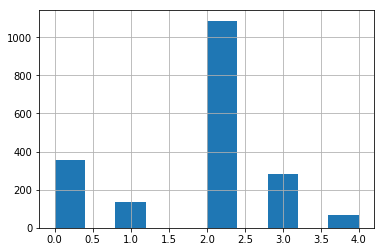

In [18]:
dist = (test_df.diagnosis.value_counts()/len(test_df))*100
print('Prediction distribution:')
print(dist)
test_df.diagnosis.hist()
plt.show()